In [1]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
import numpy as np
import datetime
import glob
import cv2
import os

### Our data

##### Load data

In [2]:
dates = ['24032019', '17042019', '01052019']
labels = ['yafim', 'zeev', 'or', 'ron', 'sergey', 'aviya', 'elnatan', 'felix']

In [6]:
x_data = []
y_data = []

In [7]:
def prep_data(dates, labels, x_data=[], y_data=[]):
    for d in dates:
        for i, l in enumerate(labels):
            for f in tqdm(glob.glob('../data/frames/{0}/{1}/32/*.png'.format(d, l))):
                x_data.append(cv2.imread(f, cv2.IMREAD_GRAYSCALE))
                y_data.append(i)                
    
    x_data = np.asarray(x_data)
    y_data = np.asarray(y_data)
    
    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2)
    x_train, x_test = x_train / 255.0, x_test / 255.0
    return x_train, x_test, y_train, y_test

In [5]:
def show_sample(x_data, idx):
    plt.imshow(x_data[idx])
    plt.show()

In [11]:
unique, counts = np.unique(y_test, return_counts=True)
np.asarray((unique, counts)).T

NameError: name 'y_test' is not defined

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(32, 32)),
    tf.keras.layers.Dense(512, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(len(labels), activation=tf.nn.softmax)
])

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

In [5]:
def set_curr_time():
    dt = datetime.datetime.now()
    curr_dt = '{0}{1}{2}_{3}_{4}'.format(datetime.datetime.now().year, datetime.datetime.now().month,
                                       datetime.datetime.now().day, datetime.datetime.now().hour,
                                      datetime.datetime.now().minute)
    return curr_dt

In [ ]:
tb_callback = tf.keras.callbacks.TensorBoard(log_dir='./logs/{0}'.format(curr_dt), histogram_freq=0, write_graph=True, write_images=True)

In [ ]:
model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=256, epochs=50, callbacks=[tb_callback])

In [ ]:
model.evaluate(x_test, y_test)

In [ ]:
conf_list = [
    [32, 512, 0.2],
    [32, 256, 0.2],
    [32, 512, 0.1],
]

In [6]:
def custom_model(config, model_weights=None):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(conf[0], conf[0])),
        tf.keras.layers.Dense(conf[1], activation=tf.nn.relu),
        tf.keras.layers.Dropout(conf[2]),
        tf.keras.layers.Dense(len(labels), activation=tf.nn.softmax)
    ])
    if model_weights is not None:
        print('loading pre-trained model')
        model.load_weights(model_weights, by_name=True)
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [7]:
def run_custom_training(conf_list, x_train, y_train, x_test, y_test, n_epochs=50, n_batch_size=256, model_path_prefix=None, model_weights=None):
    for conf in conf_list:
        curr_dt = set_curr_time()
        tb_callback = tf.keras.callbacks.TensorBoard(log_dir='./logs/{0}_{1}'.format(conf, curr_dt),
                                                     histogram_freq=0, write_graph=True)
        model = custom_model(conf, model_weights)
        model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=n_batch_size,
                  epochs=n_epochs, callbacks=[tb_callback])
        model.evaluate(x_test, y_test)
        if model_path_prefix is None:
            model.save('../models/{0}_{1}.h5'.format(conf, curr_dt))
        else:
            model.save('../models/{0}_{1}_{2}.h5'.format(model_path_prefix, conf, curr_dt))

##### continues training

In [ ]:
c_model = tf.keras.models.load_model('../models/[32, 512, 0.1]_201953_12_56.h5')

In [ ]:
c_model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=256,
              epochs=50, callbacks=[tb_callback])

In [ ]:
c_model.evaluate(x_test, y_test)

In [ ]:
for model_path in glob.glob('../models/*.h5'):
    print(model_path)
    best_loaded = tf.keras.models.load_model(model_path)
    best_loaded.evaluate(x_test, y_test)

In [ ]:
best_loaded = tf.keras.models.load_model('../models/[32, 512, 0.1]_201953_12_56.h5')
test_predictions = best_loaded.predict(x_test)

In [ ]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_test, np.argmax(test_predictions,axis=1))
confusion

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(confusion, labels, labels)
plt.figure(figsize = (12, 9))
sn.set(font_scale=1.2)
sn.heatmap(df_cm, annot=True, fmt='.5g', annot_kws={"size": 12})

In [ ]:
df_cm

### devided images (biased)

In [ ]:
x_data = []
y_data = []

In [12]:
for d in dates:
    for l_idx, l in enumerate(labels):
        f_path = '../data/frames/{0}/{1}/32'.format(d, l)
        if os.path.exists(f_path):
            f_list = os.listdir(f_path)
            for i in tqdm(range(0, len(f_list) - 1)):
                img1 = cv2.imread('{0}/{1}'.format(f_path, f_list[i]), cv2.IMREAD_GRAYSCALE)
                img2 = cv2.imread('{0}/{1}'.format(f_path, f_list[i+1]), cv2.IMREAD_GRAYSCALE)
                img = img1 - img2
                x_data.append(img)
                y_data.append(l_idx)

 47%|████▋     | 10341/21999 [00:01<00:02, 5740.07it/s]


KeyboardInterrupt: 

In [ ]:
x_data = np.asarray(x_data)
y_data = np.asarray(y_data)

In [ ]:
x_data.shape

In [ ]:
y_data

In [ ]:
plt.imshow(x_data[0])
plt.show()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2)

In [ ]:
x_train, x_test = x_train / 255.0, x_test / 255.0

In [ ]:
x_train.shape

In [ ]:
unique, counts = np.unique(y_test, return_counts=True)
np.asarray((unique, counts)).T

In [ ]:
for conf in conf_list:
    curr_dt = set_curr_time()
    tb_callback = tf.keras.callbacks.TensorBoard(log_dir='./logs/sub_imgs_{0}_{1}'.format(conf, curr_dt),
                                                 histogram_freq=0, write_graph=True)
    model = custom_model(conf)
    model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=256,
              epochs=50, callbacks=[tb_callback])
    model.evaluate(x_test, y_test)
    model.save('../models/sub_imgs_{0}_{1}.h5'.format(conf, curr_dt))

### 5 labels (a lot of data for each)

In [8]:
labels = ['zeev', 'or', 'ron', 'aviya', 'felix']

In [9]:
x_train, x_test, y_train, y_test = prep_data(dates, labels, x_data, y_data)

100%|██████████| 3000/3000 [00:00<00:00, 12978.14it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 30000/30000 [00:02<00:00, 12673.26it/s]
0it [00:00, ?it/s]
100%|██████████| 22000/22000 [00:01<00:00, 12512.38it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 21000/21000 [00:01<00:00, 11962.42it/s]


In [10]:
show_sample(1)

TypeError: show_sample() missing 1 required positional argument: 'idx'

In [ ]:
run_custom_training(conf_list, x_train, y_train, x_test, y_test,
                    model_path_prefix='5_lbls', model_weights='../models/[32, 512, 0.1]_201953_12_56.h5')

### TF core model

In [12]:
dates = ['24032019', '17042019', '01052019']
labels = ['zeev', 'or', 'ron', 'aviya', 'felix']

In [13]:
n_inputs = 32 * 32
n_hidden1 = 300
n_hidden2 = 100

n_outputs = len(labels)
batch_norm_momentum = 0.9
learning_rate = 0.001
TRAIN_PERCENT_SPLIT = 0.8
VALID_PERCENT_SPLIT = 0.5
VALID_AND_TEST = 1 - TRAIN_PERCENT_SPLIT

n_epochs = 15
batch_size = 256

model_path_prefix='tf_core'

In [ ]:
x_train, x_test, y_train, y_test = prep_data(dates, labels)

In [14]:
# stratified data
x_train = [] 
y_train = []

x_valid = []
y_valid = []

x_test  = []
y_test  = []


# for i, l in enumerate(labels):
for d in dates:
    for i, l in enumerate(labels):
        x_data = []
        y_data = []
        for f in tqdm(glob.glob('../data/frames/{0}/{1}/32/*.png'.format(d, l))):
            x_data.append(cv2.imread(f, cv2.IMREAD_GRAYSCALE))
            y_data.append(i)
        x_train_label, xx_test_label, y_train_label, yy_test_label \
                         = train_test_split(x_data, y_data, test_size=VALID_AND_TEST)
        x_valid_label, x_test_label, y_valid_label, y_test_label \
                     = train_test_split(xx_test_label, yy_test_label, test_size=VALID_PERCENT_SPLIT)  

        x_train.append(x_train_label)
        y_train.append(y_train_label)
        x_test.append(x_test_label)
        y_test.append(y_test_label)
        x_valid.append(x_valid_label)
        y_valid.append(y_valid_label)

100%|██████████| 3000/3000 [00:00<00:00, 8200.41it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 30000/30000 [00:03<00:00, 8129.14it/s]
0it [00:00, ?it/s]
100%|██████████| 22000/22000 [00:02<00:00, 8481.26it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 21000/21000 [00:02<00:00, 8250.12it/s]


In [15]:
import itertools
x_train = list(itertools.chain.from_iterable(x_train))
y_train = list(itertools.chain.from_iterable(y_train))
x_test = list(itertools.chain.from_iterable(x_test))
y_test = list(itertools.chain.from_iterable(y_test))
x_valid = list(itertools.chain.from_iterable(x_valid))
y_valid = list(itertools.chain.from_iterable(y_valid))

x_valid = np.asarray(x_valid)
y_valid = np.asarray(y_valid)
x_test  = np.asarray(x_test)
y_test  = np.asarray(y_test)
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)

In [16]:
np.unique(y_test)

array([0, 1, 2, 3, 4])

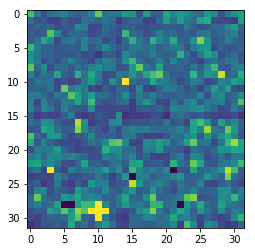

In [17]:
show_sample(x_train, 5)

In [18]:
# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
reset_graph()

In [19]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    if (len(X) / batch_size) % 10 is 0:
        n_batches = (len(X) // batch_size)
    else:
        n_batches = (len(X) // batch_size) + 1
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        X_batch = X_batch.reshape(batch_size, n_inputs)
        yield X_batch, y_batch

In [ ]:
from functools import partial

In [ ]:
tf.reset_default_graph()
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")
training = tf.placeholder_with_default(False, shape=(), name='training')
my_batch_norm_layer = partial(tf.layers.batch_normalization, training=training, momentum=0.9)

In [ ]:
with tf.name_scope("dnn"):
    he_init = tf.variance_scaling_initializer()

    my_batch_norm_layer = partial(
            tf.layers.batch_normalization,
            training=training,
            momentum=batch_norm_momentum)

    my_dense_layer = partial(
            tf.layers.dense,
            kernel_initializer=he_init)

    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    bn1 = tf.nn.elu(my_batch_norm_layer(hidden1))
    hidden2 = my_dense_layer(bn1, n_hidden2, name="hidden2")
    bn2 = tf.nn.elu(my_batch_norm_layer(hidden2))
    logits_before_bn = my_dense_layer(bn2, n_outputs, name="outputs")
    logits = my_batch_norm_layer(logits_before_bn)

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [ ]:
curr_dt = set_curr_time()
logdir='./logs/{0}_{1}'.format(model_path_prefix, curr_dt)
ce_summary = tf.summary.scalar('cross-entropy', loss)
acc_summary = tf.summary.scalar("accuracy", accuracy)
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

In [ ]:
print(len(x_train) // batch_size)
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

i =0
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in tqdm(shuffle_batch(x_train, y_train, batch_size)):
            sess.run([training_op, extra_update_ops],
                                 feed_dict={training: True, X: X_batch, y: y_batch})
            summary_str = ce_summary.eval(feed_dict={training: False, X: x_train.reshape(-1, n_inputs), y: y_train})
            file_writer.add_summary(summary_str, i)
            i += 1
        accuracy_val = accuracy.eval(feed_dict={training: False, X: x_test.reshape(-1, n_inputs), y: y_test})
        accuracy_val_str = acc_summary.eval(feed_dict={training: False, X: x_test.reshape(-1, n_inputs), y: y_test})
        file_writer.add_summary(accuracy_val_str, i)
        summary_str = ce_summary.eval(feed_dict={training: False, X: x_test.reshape(-1, n_inputs), y: y_test})
        file_writer.add_summary(summary_str, i)

        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, '../models/{0}_{1}.ckpt'.format(model_path_prefix, curr_dt))
file_writer.flush()
file_writer.close()

### TF core model 2 keras

In [20]:
conf_list = [
    [32, 300, 100, 0.4],
    [32, 300, 100, 0.2],
#     [32, 256, 0.2],
#     [32, 512, 0.1],
]

##### acctivation elu

In [25]:
def custom_model(conf, model_weights=None):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(conf[0], conf[0])),
        tf.keras.layers.Dense(conf[1], activation=tf.nn.elu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(conf[2], activation=tf.nn.elu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(conf[3]),
        tf.keras.layers.Dense(len(labels), activation=tf.nn.softmax)
    ])
    if model_weights is not None:
        print('loading pre-trained model')
        model.load_weights(model_weights, by_name=True)
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [28]:
run_custom_training(conf_list, x_train, y_train, x_valid, y_valid,1000, 512,model_path_prefix='5_lbls_elu')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 113600 samples, validate on 14200 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/1000
113600/113600 [==============================] - 3s 30us/sample - loss: 1.3181 - acc: 0.4675 - val_loss: 1.2267 - val_acc: 0.4735
Epoch 2/1000
113600/113600 [==============================] - 3s 25us/sample - loss: 1.0406 - acc: 0.5675 - val_loss: 1.2050 - val_acc: 0.4975
Epoch 3/1000
113600/113600 [==============================] - 3s 24us/sample - loss: 0.9788 - acc: 0.5994 - val_loss: 1.3946 - val_acc: 0.4408
Epoch 4/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.9338 - acc: 0.6191 - val_loss: 1.1491 - val_acc: 0.5128
Epoch 5/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.8963 - acc: 0.6367 - val_loss: 1.0464 - val_acc: 0.5727

Epoch 107/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.3856 - acc: 0.8451 - val_loss: 1.3109 - val_acc: 0.6994
Epoch 108/1000
113600/113600 [==============================] - 3s 25us/sample - loss: 0.3877 - acc: 0.8447 - val_loss: 1.3872 - val_acc: 0.6777
Epoch 109/1000
113600/113600 [==============================] - 3s 25us/sample - loss: 0.3913 - acc: 0.8428 - val_loss: 1.2290 - val_acc: 0.6709
Epoch 110/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.3816 - acc: 0.8473 - val_loss: 1.1801 - val_acc: 0.7023
Epoch 111/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.3832 - acc: 0.8451 - val_loss: 1.3175 - val_acc: 0.6799
Epoch 112/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.3867 - acc: 0.8447 - val_loss: 1.1664 - val_acc: 0.7087
Epoch 113/1000
113600/113600 [==============================] - 3s 27us/sample - loss: 0.3789 - acc: 0.8488 - val_loss: 1.1470 - v

113600/113600 [==============================] - 3s 26us/sample - loss: 0.3199 - acc: 0.8707 - val_loss: 1.4723 - val_acc: 0.6993
Epoch 220/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.3212 - acc: 0.8706 - val_loss: 1.2375 - val_acc: 0.7119
Epoch 221/1000
113600/113600 [==============================] - 3s 25us/sample - loss: 0.3194 - acc: 0.8708 - val_loss: 1.4463 - val_acc: 0.7096
Epoch 222/1000
113600/113600 [==============================] - 638s 6ms/sample - loss: 0.3204 - acc: 0.8693 - val_loss: 1.5194 - val_acc: 0.6943
Epoch 223/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.3212 - acc: 0.8714 - val_loss: 1.4345 - val_acc: 0.7025
Epoch 224/1000
113600/113600 [==============================] - 3s 25us/sample - loss: 0.3194 - acc: 0.8703 - val_loss: 1.5497 - val_acc: 0.6842
Epoch 225/1000
113600/113600 [==============================] - 3s 25us/sample - loss: 0.3211 - acc: 0.8698 - val_loss: 1.3120 - val_acc: 0.7079

113600/113600 [==============================] - 3s 28us/sample - loss: 0.2865 - acc: 0.8843 - val_loss: 1.2738 - val_acc: 0.7226
Epoch 332/1000
113600/113600 [==============================] - 3s 28us/sample - loss: 0.2889 - acc: 0.8836 - val_loss: 1.5413 - val_acc: 0.7028
Epoch 333/1000
113600/113600 [==============================] - 3s 28us/sample - loss: 0.2889 - acc: 0.8825 - val_loss: 1.4094 - val_acc: 0.7120
Epoch 334/1000
113600/113600 [==============================] - 3s 28us/sample - loss: 0.2893 - acc: 0.8819 - val_loss: 1.5746 - val_acc: 0.7035
Epoch 335/1000
113600/113600 [==============================] - 3s 27us/sample - loss: 0.2855 - acc: 0.8839 - val_loss: 1.4800 - val_acc: 0.7111
Epoch 336/1000
113600/113600 [==============================] - 3s 28us/sample - loss: 0.2890 - acc: 0.8827 - val_loss: 1.4682 - val_acc: 0.6989
Epoch 337/1000
113600/113600 [==============================] - 3s 27us/sample - loss: 0.2846 - acc: 0.8836 - val_loss: 1.3064 - val_acc: 0.7254


113600/113600 [==============================] - 3s 26us/sample - loss: 0.2668 - acc: 0.8923 - val_loss: 1.4028 - val_acc: 0.7225
Epoch 444/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.2646 - acc: 0.8930 - val_loss: 1.3903 - val_acc: 0.7318
Epoch 445/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.2635 - acc: 0.8933 - val_loss: 1.3542 - val_acc: 0.7060
Epoch 446/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.2654 - acc: 0.8931 - val_loss: 1.3338 - val_acc: 0.7220
Epoch 447/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.2651 - acc: 0.8931 - val_loss: 1.4609 - val_acc: 0.7112
Epoch 448/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.2675 - acc: 0.8908 - val_loss: 1.5520 - val_acc: 0.7090
Epoch 449/1000
113600/113600 [==============================] - 3s 27us/sample - loss: 0.2653 - acc: 0.8927 - val_loss: 1.4900 - val_acc: 0.7131


113600/113600 [==============================] - 3s 25us/sample - loss: 0.2492 - acc: 0.8986 - val_loss: 1.3254 - val_acc: 0.7289
Epoch 556/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.2475 - acc: 0.8993 - val_loss: 1.3941 - val_acc: 0.7242
Epoch 557/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.2451 - acc: 0.9014 - val_loss: 1.4435 - val_acc: 0.7154
Epoch 558/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.2523 - acc: 0.8980 - val_loss: 1.4868 - val_acc: 0.7199
Epoch 559/1000
113600/113600 [==============================] - 3s 25us/sample - loss: 0.2506 - acc: 0.8988 - val_loss: 1.7724 - val_acc: 0.7073
Epoch 560/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.2500 - acc: 0.8993 - val_loss: 1.6118 - val_acc: 0.7247
Epoch 561/1000
113600/113600 [==============================] - 3s 25us/sample - loss: 0.2517 - acc: 0.8979 - val_loss: 1.4187 - val_acc: 0.7244


113600/113600 [==============================] - 3s 26us/sample - loss: 0.2389 - acc: 0.9020 - val_loss: 1.4810 - val_acc: 0.7232
Epoch 668/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.2397 - acc: 0.9035 - val_loss: 1.5449 - val_acc: 0.7200
Epoch 669/1000
113600/113600 [==============================] - 3s 25us/sample - loss: 0.2407 - acc: 0.9026 - val_loss: 1.7302 - val_acc: 0.7153
Epoch 670/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.2367 - acc: 0.9038 - val_loss: 1.4318 - val_acc: 0.7175
Epoch 671/1000
113600/113600 [==============================] - 3s 25us/sample - loss: 0.2389 - acc: 0.9037 - val_loss: 1.5438 - val_acc: 0.7182
Epoch 672/1000
113600/113600 [==============================] - 3s 27us/sample - loss: 0.2385 - acc: 0.9043 - val_loss: 1.5315 - val_acc: 0.7238
Epoch 673/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.2391 - acc: 0.9040 - val_loss: 1.6219 - val_acc: 0.7107


113600/113600 [==============================] - 3s 26us/sample - loss: 0.2304 - acc: 0.9074 - val_loss: 1.4957 - val_acc: 0.7272
Epoch 780/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.2290 - acc: 0.9077 - val_loss: 1.6161 - val_acc: 0.7215
Epoch 781/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.2274 - acc: 0.9074 - val_loss: 1.4453 - val_acc: 0.7277
Epoch 782/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.2331 - acc: 0.9062 - val_loss: 1.3930 - val_acc: 0.7287
Epoch 783/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.2309 - acc: 0.9068 - val_loss: 1.5106 - val_acc: 0.7332
Epoch 784/1000
113600/113600 [==============================] - 3s 27us/sample - loss: 0.2255 - acc: 0.9086 - val_loss: 1.6307 - val_acc: 0.7196
Epoch 785/1000
113600/113600 [==============================] - 3s 27us/sample - loss: 0.2284 - acc: 0.9073 - val_loss: 1.4013 - val_acc: 0.7318


113600/113600 [==============================] - 3s 26us/sample - loss: 0.2208 - acc: 0.9108 - val_loss: 1.5940 - val_acc: 0.7220
Epoch 892/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.2201 - acc: 0.9106 - val_loss: 1.5500 - val_acc: 0.7261
Epoch 893/1000
113600/113600 [==============================] - 3s 25us/sample - loss: 0.2210 - acc: 0.9106 - val_loss: 1.6707 - val_acc: 0.7268
Epoch 894/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.2199 - acc: 0.9116 - val_loss: 1.6764 - val_acc: 0.7125
Epoch 895/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.2211 - acc: 0.9114 - val_loss: 1.5760 - val_acc: 0.7270
Epoch 896/1000
113600/113600 [==============================] - 3s 25us/sample - loss: 0.2181 - acc: 0.9125 - val_loss: 1.7252 - val_acc: 0.7142
Epoch 897/1000
113600/113600 [==============================] - 3s 25us/sample - loss: 0.2213 - acc: 0.9101 - val_loss: 1.4344 - val_acc: 0.7307


113600/113600 [==============================] - 3s 24us/sample - loss: 0.9942 - acc: 0.5917 - val_loss: 1.1225 - val_acc: 0.5327
Epoch 3/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.9155 - acc: 0.6278 - val_loss: 1.2547 - val_acc: 0.4920
Epoch 4/1000
113600/113600 [==============================] - 8s 69us/sample - loss: 0.8478 - acc: 0.6615 - val_loss: 2.2771 - val_acc: 0.4155
Epoch 5/1000
113600/113600 [==============================] - 11s 93us/sample - loss: 0.7992 - acc: 0.6844 - val_loss: 2.0627 - val_acc: 0.4383
Epoch 6/1000
113600/113600 [==============================] - 11s 92us/sample - loss: 0.7490 - acc: 0.7062 - val_loss: 1.0996 - val_acc: 0.6010
Epoch 7/1000
113600/113600 [==============================] - 11s 93us/sample - loss: 0.7064 - acc: 0.7267 - val_loss: 1.2475 - val_acc: 0.5820
Epoch 8/1000
113600/113600 [==============================] - 11s 93us/sample - loss: 0.6689 - acc: 0.7433 - val_loss: 1.2421 - val_acc: 0.5730
Epoch 9/

Epoch 59/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.2704 - acc: 0.8986 - val_loss: 1.3772 - val_acc: 0.6869
Epoch 60/1000
113600/113600 [==============================] - 11s 95us/sample - loss: 0.2673 - acc: 0.9000 - val_loss: 1.3200 - val_acc: 0.6905
Epoch 61/1000
113600/113600 [==============================] - 11s 94us/sample - loss: 0.2635 - acc: 0.9011 - val_loss: 1.5892 - val_acc: 0.6734
Epoch 62/1000
113600/113600 [==============================] - 10s 92us/sample - loss: 0.2638 - acc: 0.9012 - val_loss: 2.0807 - val_acc: 0.6107
Epoch 63/1000
113600/113600 [==============================] - 613s 5ms/sample - loss: 0.2614 - acc: 0.9022 - val_loss: 1.5864 - val_acc: 0.6756
Epoch 64/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.2595 - acc: 0.9028 - val_loss: 1.7895 - val_acc: 0.6563
Epoch 65/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.2560 - acc: 0.9033 - val_loss: 1.3664 - val_

Epoch 116/1000
113600/113600 [==============================] - 3s 25us/sample - loss: 0.2054 - acc: 0.9240 - val_loss: 1.4465 - val_acc: 0.7077
Epoch 117/1000
113600/113600 [==============================] - 3s 25us/sample - loss: 0.2078 - acc: 0.9233 - val_loss: 1.7131 - val_acc: 0.6811
Epoch 118/1000
113600/113600 [==============================] - 3s 25us/sample - loss: 0.2087 - acc: 0.9222 - val_loss: 1.4853 - val_acc: 0.6929
Epoch 119/1000
113600/113600 [==============================] - 3s 25us/sample - loss: 0.2065 - acc: 0.9235 - val_loss: 1.6876 - val_acc: 0.6961
Epoch 120/1000
113600/113600 [==============================] - 3s 25us/sample - loss: 0.2041 - acc: 0.9242 - val_loss: 1.6118 - val_acc: 0.6886
Epoch 121/1000
113600/113600 [==============================] - 3s 27us/sample - loss: 0.2024 - acc: 0.9247 - val_loss: 1.5012 - val_acc: 0.6888
Epoch 122/1000
113600/113600 [==============================] - 3s 25us/sample - loss: 0.2049 - acc: 0.9234 - val_loss: 1.3792 - v

113600/113600 [==============================] - 3s 26us/sample - loss: 0.1664 - acc: 0.9391 - val_loss: 1.6622 - val_acc: 0.7077
Epoch 229/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.1646 - acc: 0.9395 - val_loss: 1.6239 - val_acc: 0.7099
Epoch 230/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.1600 - acc: 0.9405 - val_loss: 1.7176 - val_acc: 0.6917
Epoch 231/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.1615 - acc: 0.9414 - val_loss: 1.8058 - val_acc: 0.7080
Epoch 232/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.1641 - acc: 0.9398 - val_loss: 1.5599 - val_acc: 0.7017
Epoch 233/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.1627 - acc: 0.9400 - val_loss: 1.7107 - val_acc: 0.6919
Epoch 234/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.1614 - acc: 0.9403 - val_loss: 1.6653 - val_acc: 0.7079


113600/113600 [==============================] - 3s 26us/sample - loss: 0.1422 - acc: 0.9476 - val_loss: 1.5476 - val_acc: 0.7214
Epoch 341/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.1425 - acc: 0.9483 - val_loss: 1.7193 - val_acc: 0.7077
Epoch 342/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.1408 - acc: 0.9480 - val_loss: 1.9899 - val_acc: 0.6889
Epoch 343/1000
113600/113600 [==============================] - 3s 27us/sample - loss: 0.1430 - acc: 0.9471 - val_loss: 2.0189 - val_acc: 0.6918
Epoch 344/1000
113600/113600 [==============================] - 3s 28us/sample - loss: 0.1405 - acc: 0.9485 - val_loss: 1.9615 - val_acc: 0.6968
Epoch 345/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.1367 - acc: 0.9505 - val_loss: 2.0259 - val_acc: 0.6989
Epoch 346/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.1400 - acc: 0.9485 - val_loss: 1.8586 - val_acc: 0.7097


113600/113600 [==============================] - 3s 26us/sample - loss: 0.1278 - acc: 0.9537 - val_loss: 1.6280 - val_acc: 0.7127
Epoch 453/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.1286 - acc: 0.9536 - val_loss: 1.9307 - val_acc: 0.7082
Epoch 454/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.1275 - acc: 0.9537 - val_loss: 1.6819 - val_acc: 0.7105
Epoch 455/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.1287 - acc: 0.9537 - val_loss: 1.8536 - val_acc: 0.7135
Epoch 456/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.1297 - acc: 0.9523 - val_loss: 1.7497 - val_acc: 0.7183
Epoch 457/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.1307 - acc: 0.9528 - val_loss: 1.9873 - val_acc: 0.6878
Epoch 458/1000
113600/113600 [==============================] - 3s 27us/sample - loss: 0.1281 - acc: 0.9533 - val_loss: 1.9177 - val_acc: 0.7006


113600/113600 [==============================] - 3s 26us/sample - loss: 0.1197 - acc: 0.9557 - val_loss: 1.7524 - val_acc: 0.7210
Epoch 565/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.1184 - acc: 0.9564 - val_loss: 1.7553 - val_acc: 0.7194
Epoch 566/1000
113600/113600 [==============================] - 3s 27us/sample - loss: 0.1208 - acc: 0.9557 - val_loss: 1.6976 - val_acc: 0.7208
Epoch 567/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.1179 - acc: 0.9565 - val_loss: 1.6991 - val_acc: 0.7192
Epoch 568/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.1164 - acc: 0.9578 - val_loss: 1.6870 - val_acc: 0.7195
Epoch 569/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.1153 - acc: 0.9582 - val_loss: 1.7597 - val_acc: 0.7192
Epoch 570/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.1193 - acc: 0.9570 - val_loss: 1.8057 - val_acc: 0.7205


113600/113600 [==============================] - 3s 26us/sample - loss: 0.1114 - acc: 0.9594 - val_loss: 1.7915 - val_acc: 0.7161
Epoch 677/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.1102 - acc: 0.9606 - val_loss: 1.7711 - val_acc: 0.7198
Epoch 678/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.1113 - acc: 0.9599 - val_loss: 2.0475 - val_acc: 0.7044
Epoch 679/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.1087 - acc: 0.9600 - val_loss: 1.6310 - val_acc: 0.7299
Epoch 680/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.1092 - acc: 0.9607 - val_loss: 1.7937 - val_acc: 0.7203
Epoch 681/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.1100 - acc: 0.9602 - val_loss: 1.8314 - val_acc: 0.7120
Epoch 682/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.1105 - acc: 0.9597 - val_loss: 2.0062 - val_acc: 0.7106


113600/113600 [==============================] - 3s 28us/sample - loss: 0.1036 - acc: 0.9621 - val_loss: 1.6982 - val_acc: 0.7313
Epoch 789/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.1038 - acc: 0.9619 - val_loss: 1.9780 - val_acc: 0.7158
Epoch 790/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.1072 - acc: 0.9614 - val_loss: 1.8919 - val_acc: 0.7196
Epoch 791/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.1039 - acc: 0.9621 - val_loss: 2.0236 - val_acc: 0.7127
Epoch 792/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.1060 - acc: 0.9617 - val_loss: 1.8570 - val_acc: 0.7128
Epoch 793/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.1009 - acc: 0.9627 - val_loss: 1.7598 - val_acc: 0.7291
Epoch 794/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.1017 - acc: 0.9627 - val_loss: 1.8077 - val_acc: 0.7213


113600/113600 [==============================] - 3s 26us/sample - loss: 0.0963 - acc: 0.9648 - val_loss: 1.8629 - val_acc: 0.7147
Epoch 901/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.1004 - acc: 0.9636 - val_loss: 1.7186 - val_acc: 0.7263
Epoch 902/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.0984 - acc: 0.9644 - val_loss: 1.8721 - val_acc: 0.7218
Epoch 903/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.1010 - acc: 0.9640 - val_loss: 1.8808 - val_acc: 0.7261
Epoch 904/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.0996 - acc: 0.9637 - val_loss: 1.8727 - val_acc: 0.7211
Epoch 905/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.0974 - acc: 0.9641 - val_loss: 2.0285 - val_acc: 0.7113
Epoch 906/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.0967 - acc: 0.9650 - val_loss: 1.8539 - val_acc: 0.7255


##### activation relu

In [29]:
def custom_model(conf, model_weights=None):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(conf[0], conf[0])),
        tf.keras.layers.Dense(conf[1], activation=tf.nn.relu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(conf[2], activation=tf.nn.relu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(conf[3]),
        tf.keras.layers.Dense(len(labels), activation=tf.nn.softmax)
    ])
    if model_weights is not None:
        print('loading pre-trained model')
        model.load_weights(model_weights, by_name=True)
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [30]:
run_custom_training(conf_list, x_train, y_train, x_valid, y_valid,1000, 512,model_path_prefix='5_lbls_relu')

Train on 113600 samples, validate on 14200 samples
Epoch 1/1000
113600/113600 [==============================] - 3s 29us/sample - loss: 1.3166 - acc: 0.4673 - val_loss: 1.3530 - val_acc: 0.4725
Epoch 2/1000
113600/113600 [==============================] - 3s 25us/sample - loss: 1.0054 - acc: 0.5860 - val_loss: 1.1953 - val_acc: 0.5296
Epoch 3/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.9325 - acc: 0.6226 - val_loss: 1.3136 - val_acc: 0.5127
Epoch 4/1000
113600/113600 [==============================] - 3s 27us/sample - loss: 0.8785 - acc: 0.6503 - val_loss: 1.3962 - val_acc: 0.4858
Epoch 5/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.8357 - acc: 0.6677 - val_loss: 1.1096 - val_acc: 0.5689
Epoch 6/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.8013 - acc: 0.6853 - val_loss: 0.9448 - val_acc: 0.6262
Epoch 7/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.7765

Epoch 114/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.3839 - acc: 0.8468 - val_loss: 1.1239 - val_acc: 0.6794
Epoch 115/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.3811 - acc: 0.8488 - val_loss: 1.0307 - val_acc: 0.7047
Epoch 116/1000
113600/113600 [==============================] - 3s 25us/sample - loss: 0.3783 - acc: 0.8489 - val_loss: 1.0766 - val_acc: 0.7044
Epoch 117/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.3757 - acc: 0.8506 - val_loss: 1.1548 - val_acc: 0.6967
Epoch 118/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.3782 - acc: 0.8497 - val_loss: 1.0534 - val_acc: 0.6973
Epoch 119/1000
113600/113600 [==============================] - 3s 25us/sample - loss: 0.3781 - acc: 0.8480 - val_loss: 1.2178 - val_acc: 0.6866
Epoch 120/1000
113600/113600 [==============================] - 3s 27us/sample - loss: 0.3736 - acc: 0.8515 - val_loss: 1.1275 - v

113600/113600 [==============================] - 3s 26us/sample - loss: 0.3177 - acc: 0.8729 - val_loss: 1.3057 - val_acc: 0.7086
Epoch 227/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.3125 - acc: 0.8752 - val_loss: 1.1707 - val_acc: 0.7202
Epoch 228/1000
113600/113600 [==============================] - 3s 25us/sample - loss: 0.3140 - acc: 0.8744 - val_loss: 1.4543 - val_acc: 0.6844
Epoch 229/1000
113600/113600 [==============================] - 3s 25us/sample - loss: 0.3127 - acc: 0.8736 - val_loss: 1.3068 - val_acc: 0.7022
Epoch 230/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.3088 - acc: 0.8758 - val_loss: 1.1952 - val_acc: 0.7167
Epoch 231/1000
113600/113600 [==============================] - 3s 25us/sample - loss: 0.3102 - acc: 0.8762 - val_loss: 1.3530 - val_acc: 0.7057
Epoch 232/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.3087 - acc: 0.8758 - val_loss: 1.2724 - val_acc: 0.7090


113600/113600 [==============================] - 3s 26us/sample - loss: 0.2699 - acc: 0.8920 - val_loss: 1.3618 - val_acc: 0.7132
Epoch 339/1000
113600/113600 [==============================] - 3s 25us/sample - loss: 0.2703 - acc: 0.8920 - val_loss: 1.5637 - val_acc: 0.6942
Epoch 340/1000
113600/113600 [==============================] - 3s 25us/sample - loss: 0.2683 - acc: 0.8920 - val_loss: 1.1920 - val_acc: 0.7256
Epoch 341/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.2681 - acc: 0.8927 - val_loss: 1.4428 - val_acc: 0.7058
Epoch 342/1000
113600/113600 [==============================] - 3s 25us/sample - loss: 0.2718 - acc: 0.8907 - val_loss: 1.3139 - val_acc: 0.7146
Epoch 343/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.2678 - acc: 0.8932 - val_loss: 1.2535 - val_acc: 0.7296
Epoch 344/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.2673 - acc: 0.8925 - val_loss: 1.3991 - val_acc: 0.7189


113600/113600 [==============================] - 3s 26us/sample - loss: 0.2439 - acc: 0.9017 - val_loss: 1.4361 - val_acc: 0.7180
Epoch 451/1000
113600/113600 [==============================] - 3s 25us/sample - loss: 0.2402 - acc: 0.9031 - val_loss: 1.4477 - val_acc: 0.7202
Epoch 452/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.2399 - acc: 0.9044 - val_loss: 1.3395 - val_acc: 0.7250
Epoch 453/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.2416 - acc: 0.9030 - val_loss: 1.4750 - val_acc: 0.7160
Epoch 454/1000
113600/113600 [==============================] - 3s 27us/sample - loss: 0.2394 - acc: 0.9046 - val_loss: 1.3947 - val_acc: 0.7291
Epoch 455/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.2379 - acc: 0.9045 - val_loss: 1.3165 - val_acc: 0.7394
Epoch 456/1000
113600/113600 [==============================] - 3s 25us/sample - loss: 0.2367 - acc: 0.9036 - val_loss: 1.4133 - val_acc: 0.7125


113600/113600 [==============================] - 3s 26us/sample - loss: 0.2170 - acc: 0.9129 - val_loss: 1.4366 - val_acc: 0.7389
Epoch 563/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.2134 - acc: 0.9150 - val_loss: 1.4918 - val_acc: 0.7323
Epoch 564/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.2160 - acc: 0.9124 - val_loss: 1.4190 - val_acc: 0.7308
Epoch 565/1000
113600/113600 [==============================] - 3s 25us/sample - loss: 0.2172 - acc: 0.9117 - val_loss: 1.5773 - val_acc: 0.7200
Epoch 566/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.2161 - acc: 0.9136 - val_loss: 1.4799 - val_acc: 0.7230
Epoch 567/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.2156 - acc: 0.9142 - val_loss: 1.6274 - val_acc: 0.7170
Epoch 568/1000
113600/113600 [==============================] - 3s 25us/sample - loss: 0.2158 - acc: 0.9132 - val_loss: 1.4056 - val_acc: 0.7263


113600/113600 [==============================] - 3s 25us/sample - loss: 0.1952 - acc: 0.9214 - val_loss: 1.6054 - val_acc: 0.7196
Epoch 675/1000
113600/113600 [==============================] - 3s 25us/sample - loss: 0.1988 - acc: 0.9202 - val_loss: 1.6482 - val_acc: 0.7142
Epoch 676/1000
113600/113600 [==============================] - 3s 25us/sample - loss: 0.1992 - acc: 0.9204 - val_loss: 1.5027 - val_acc: 0.7371
Epoch 677/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.1958 - acc: 0.9215 - val_loss: 1.6231 - val_acc: 0.7176
Epoch 678/1000
113600/113600 [==============================] - 3s 27us/sample - loss: 0.1985 - acc: 0.9215 - val_loss: 1.4721 - val_acc: 0.7356
Epoch 679/1000
113600/113600 [==============================] - 3s 25us/sample - loss: 0.1965 - acc: 0.9217 - val_loss: 1.6304 - val_acc: 0.7223
Epoch 680/1000
113600/113600 [==============================] - 3s 25us/sample - loss: 0.1959 - acc: 0.9213 - val_loss: 1.5385 - val_acc: 0.7333


113600/113600 [==============================] - 3s 26us/sample - loss: 0.1826 - acc: 0.9273 - val_loss: 1.5615 - val_acc: 0.7371
Epoch 787/1000
113600/113600 [==============================] - 3s 25us/sample - loss: 0.1808 - acc: 0.9285 - val_loss: 1.9472 - val_acc: 0.6963
Epoch 788/1000
113600/113600 [==============================] - 3s 25us/sample - loss: 0.1814 - acc: 0.9274 - val_loss: 1.7247 - val_acc: 0.7282
Epoch 789/1000
113600/113600 [==============================] - 3s 25us/sample - loss: 0.1850 - acc: 0.9258 - val_loss: 1.4986 - val_acc: 0.7375
Epoch 790/1000
113600/113600 [==============================] - 3s 27us/sample - loss: 0.1809 - acc: 0.9285 - val_loss: 1.7535 - val_acc: 0.7109
Epoch 791/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.1802 - acc: 0.9280 - val_loss: 1.5054 - val_acc: 0.7325
Epoch 792/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.1814 - acc: 0.9270 - val_loss: 1.7089 - val_acc: 0.7150


113600/113600 [==============================] - 3s 26us/sample - loss: 0.1730 - acc: 0.9311 - val_loss: 1.7607 - val_acc: 0.7117
Epoch 899/1000
113600/113600 [==============================] - 3s 25us/sample - loss: 0.1691 - acc: 0.9335 - val_loss: 1.7829 - val_acc: 0.7092
Epoch 900/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.1665 - acc: 0.9340 - val_loss: 1.6352 - val_acc: 0.7435
Epoch 901/1000
113600/113600 [==============================] - 3s 25us/sample - loss: 0.1721 - acc: 0.9313 - val_loss: 1.5476 - val_acc: 0.7521
Epoch 902/1000
113600/113600 [==============================] - 3s 25us/sample - loss: 0.1660 - acc: 0.9338 - val_loss: 1.8925 - val_acc: 0.7142
Epoch 903/1000
113600/113600 [==============================] - 3s 25us/sample - loss: 0.1691 - acc: 0.9328 - val_loss: 1.7288 - val_acc: 0.7206
Epoch 904/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.1707 - acc: 0.9320 - val_loss: 1.5888 - val_acc: 0.7330


Epoch 10/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.5410 - acc: 0.7942 - val_loss: 1.3274 - val_acc: 0.5739
Epoch 11/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.5186 - acc: 0.8041 - val_loss: 2.5550 - val_acc: 0.4881
Epoch 12/1000
113600/113600 [==============================] - 3s 27us/sample - loss: 0.4981 - acc: 0.8127 - val_loss: 1.3367 - val_acc: 0.6027
Epoch 13/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.4811 - acc: 0.8170 - val_loss: 1.3269 - val_acc: 0.6067
Epoch 14/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.4648 - acc: 0.8249 - val_loss: 1.3000 - val_acc: 0.6340
Epoch 15/1000
113600/113600 [==============================] - 3s 25us/sample - loss: 0.4521 - acc: 0.8289 - val_loss: 1.4890 - val_acc: 0.6058
Epoch 16/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.4343 - acc: 0.8359 - val_loss: 1.1128 - val_acc:

Epoch 67/1000
113600/113600 [==============================] - 3s 25us/sample - loss: 0.2533 - acc: 0.9053 - val_loss: 1.7517 - val_acc: 0.6341
Epoch 68/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.2493 - acc: 0.9059 - val_loss: 1.4618 - val_acc: 0.6699
Epoch 69/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.2455 - acc: 0.9071 - val_loss: 1.4141 - val_acc: 0.6895
Epoch 70/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.2497 - acc: 0.9060 - val_loss: 1.2599 - val_acc: 0.7030
Epoch 71/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.2428 - acc: 0.9091 - val_loss: 1.6313 - val_acc: 0.6499
Epoch 72/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.2450 - acc: 0.9086 - val_loss: 1.4480 - val_acc: 0.6906
Epoch 73/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.2389 - acc: 0.9100 - val_loss: 1.4686 - val_acc:

Epoch 124/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.2036 - acc: 0.9245 - val_loss: 1.5402 - val_acc: 0.6846
Epoch 125/1000
113600/113600 [==============================] - 3s 25us/sample - loss: 0.2000 - acc: 0.9248 - val_loss: 1.4004 - val_acc: 0.7091
Epoch 126/1000
113600/113600 [==============================] - 3s 25us/sample - loss: 0.2017 - acc: 0.9249 - val_loss: 1.5492 - val_acc: 0.6882
Epoch 127/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.2004 - acc: 0.9257 - val_loss: 1.4603 - val_acc: 0.6979
Epoch 128/1000
113600/113600 [==============================] - 3s 25us/sample - loss: 0.2032 - acc: 0.9239 - val_loss: 1.4727 - val_acc: 0.6971
Epoch 129/1000
113600/113600 [==============================] - 3s 25us/sample - loss: 0.2057 - acc: 0.9232 - val_loss: 1.3724 - val_acc: 0.6932
Epoch 130/1000
113600/113600 [==============================] - 3s 25us/sample - loss: 0.1995 - acc: 0.9256 - val_loss: 1.6446 - v

113600/113600 [==============================] - 3s 26us/sample - loss: 0.1598 - acc: 0.9414 - val_loss: 1.5988 - val_acc: 0.6990
Epoch 237/1000
113600/113600 [==============================] - 3s 25us/sample - loss: 0.1606 - acc: 0.9412 - val_loss: 1.6958 - val_acc: 0.6965
Epoch 238/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.1607 - acc: 0.9403 - val_loss: 1.5666 - val_acc: 0.6999
Epoch 239/1000
113600/113600 [==============================] - 3s 25us/sample - loss: 0.1612 - acc: 0.9403 - val_loss: 1.5078 - val_acc: 0.7013
Epoch 240/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.1610 - acc: 0.9399 - val_loss: 1.6463 - val_acc: 0.6975
Epoch 241/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.1623 - acc: 0.9402 - val_loss: 1.8538 - val_acc: 0.6850
Epoch 242/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.1600 - acc: 0.9412 - val_loss: 1.4737 - val_acc: 0.7158


113600/113600 [==============================] - 3s 26us/sample - loss: 0.1372 - acc: 0.9497 - val_loss: 1.7150 - val_acc: 0.7059
Epoch 349/1000
113600/113600 [==============================] - 3s 25us/sample - loss: 0.1368 - acc: 0.9504 - val_loss: 1.7660 - val_acc: 0.7093
Epoch 350/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.1390 - acc: 0.9488 - val_loss: 1.5422 - val_acc: 0.7033
Epoch 351/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.1355 - acc: 0.9494 - val_loss: 1.7526 - val_acc: 0.6988
Epoch 352/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.1378 - acc: 0.9488 - val_loss: 1.6203 - val_acc: 0.7153
Epoch 353/1000
113600/113600 [==============================] - 3s 25us/sample - loss: 0.1393 - acc: 0.9488 - val_loss: 1.6893 - val_acc: 0.7150
Epoch 354/1000
113600/113600 [==============================] - 3s 25us/sample - loss: 0.1348 - acc: 0.9510 - val_loss: 1.5772 - val_acc: 0.7163


113600/113600 [==============================] - 3s 26us/sample - loss: 0.1191 - acc: 0.9561 - val_loss: 1.6785 - val_acc: 0.7192
Epoch 461/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.1193 - acc: 0.9566 - val_loss: 1.7221 - val_acc: 0.7104
Epoch 462/1000
113600/113600 [==============================] - 3s 27us/sample - loss: 0.1205 - acc: 0.9562 - val_loss: 1.7714 - val_acc: 0.7077
Epoch 463/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.1201 - acc: 0.9547 - val_loss: 1.6067 - val_acc: 0.7200
Epoch 464/1000
113600/113600 [==============================] - 3s 25us/sample - loss: 0.1165 - acc: 0.9569 - val_loss: 1.6613 - val_acc: 0.7215
Epoch 465/1000
113600/113600 [==============================] - 3s 25us/sample - loss: 0.1203 - acc: 0.9558 - val_loss: 1.6114 - val_acc: 0.7224
Epoch 466/1000
113600/113600 [==============================] - 3s 25us/sample - loss: 0.1197 - acc: 0.9562 - val_loss: 1.6519 - val_acc: 0.7074


113600/113600 [==============================] - 3s 25us/sample - loss: 0.1092 - acc: 0.9607 - val_loss: 1.7989 - val_acc: 0.7135
Epoch 573/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.1051 - acc: 0.9612 - val_loss: 1.7353 - val_acc: 0.7258
Epoch 574/1000
113600/113600 [==============================] - 3s 25us/sample - loss: 0.1041 - acc: 0.9622 - val_loss: 1.9566 - val_acc: 0.7155
Epoch 575/1000
113600/113600 [==============================] - 3s 25us/sample - loss: 0.1075 - acc: 0.9603 - val_loss: 1.7661 - val_acc: 0.7186
Epoch 576/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.1079 - acc: 0.9610 - val_loss: 1.7006 - val_acc: 0.7277
Epoch 577/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.1065 - acc: 0.9608 - val_loss: 1.8947 - val_acc: 0.7084
Epoch 578/1000
113600/113600 [==============================] - 3s 27us/sample - loss: 0.1087 - acc: 0.9599 - val_loss: 1.8612 - val_acc: 0.7134


113600/113600 [==============================] - 3s 25us/sample - loss: 0.0967 - acc: 0.9651 - val_loss: 1.7703 - val_acc: 0.7204
Epoch 685/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.0941 - acc: 0.9653 - val_loss: 1.8374 - val_acc: 0.7197
Epoch 686/1000
113600/113600 [==============================] - 3s 25us/sample - loss: 0.0966 - acc: 0.9651 - val_loss: 1.6483 - val_acc: 0.7361
Epoch 687/1000
113600/113600 [==============================] - 3s 25us/sample - loss: 0.0979 - acc: 0.9643 - val_loss: 1.9671 - val_acc: 0.7113
Epoch 688/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.0962 - acc: 0.9650 - val_loss: 1.7996 - val_acc: 0.7258
Epoch 689/1000
113600/113600 [==============================] - 3s 25us/sample - loss: 0.0951 - acc: 0.9648 - val_loss: 1.8087 - val_acc: 0.7310
Epoch 690/1000
113600/113600 [==============================] - 3s 25us/sample - loss: 0.0929 - acc: 0.9662 - val_loss: 1.8689 - val_acc: 0.7216


113600/113600 [==============================] - 3s 25us/sample - loss: 0.0906 - acc: 0.9667 - val_loss: 1.8535 - val_acc: 0.7215
Epoch 797/1000
113600/113600 [==============================] - 3s 25us/sample - loss: 0.0891 - acc: 0.9672 - val_loss: 1.8952 - val_acc: 0.7165
Epoch 798/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.0889 - acc: 0.9679 - val_loss: 1.7891 - val_acc: 0.7291
Epoch 799/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.0882 - acc: 0.9679 - val_loss: 1.8701 - val_acc: 0.7366
Epoch 800/1000
113600/113600 [==============================] - 3s 25us/sample - loss: 0.0888 - acc: 0.9671 - val_loss: 1.7716 - val_acc: 0.7275
Epoch 801/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.0887 - acc: 0.9684 - val_loss: 1.8689 - val_acc: 0.7296
Epoch 802/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.0894 - acc: 0.9678 - val_loss: 1.7287 - val_acc: 0.7330


113600/113600 [==============================] - 3s 25us/sample - loss: 0.0832 - acc: 0.9705 - val_loss: 2.0873 - val_acc: 0.7085
Epoch 909/1000
113600/113600 [==============================] - 3s 25us/sample - loss: 0.0833 - acc: 0.9698 - val_loss: 1.9846 - val_acc: 0.7205
Epoch 910/1000
113600/113600 [==============================] - 3s 25us/sample - loss: 0.0826 - acc: 0.9702 - val_loss: 2.3286 - val_acc: 0.7033
Epoch 911/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.0836 - acc: 0.9695 - val_loss: 1.7614 - val_acc: 0.7392
Epoch 912/1000
113600/113600 [==============================] - 3s 26us/sample - loss: 0.0800 - acc: 0.9704 - val_loss: 1.8676 - val_acc: 0.7297
Epoch 913/1000
113600/113600 [==============================] - 3s 25us/sample - loss: 0.0838 - acc: 0.9698 - val_loss: 1.8497 - val_acc: 0.7276
Epoch 914/1000
113600/113600 [==============================] - 3s 25us/sample - loss: 0.0804 - acc: 0.9704 - val_loss: 1.9150 - val_acc: 0.7322


### predict on test_set

In [31]:
unique, counts = np.unique(y_test, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 2500],
       [   1, 3300],
       [   2, 3300],
       [   3, 3000],
       [   4, 2100]])

In [1]:
trained_model = tf.keras.models.load_model('../models/5_lbls_relu_[32, 300, 100, 0.2]_2019518_2_11.h5')

NameError: name 'tf' is not defined

In [33]:
test_predicted = trained_model.predict(x_test)

In [42]:
acc = 0
total = 0
for i, lbl in enumerate(y_test):
#     if lbl != 1:
        total += 1
        if np.argmax(test_predicted[i]) == lbl:
            acc += 1
#     else:
#         print(lbl)
print('acc: ', (acc/total*100))

acc:  73.83098591549296


In [43]:
np.unique(y_test)

array([0, 1, 2, 3, 4])

In [44]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_test, np.argmax(test_predicted,axis=1))
confusion

array([[1916,   52,  280,  118,  134],
       [ 181, 2409,  244,  261,  205],
       [ 457,   98, 2344,  362,   39],
       [ 263,   82,  375, 2211,   69],
       [ 247,  110,   75,   64, 1604]])

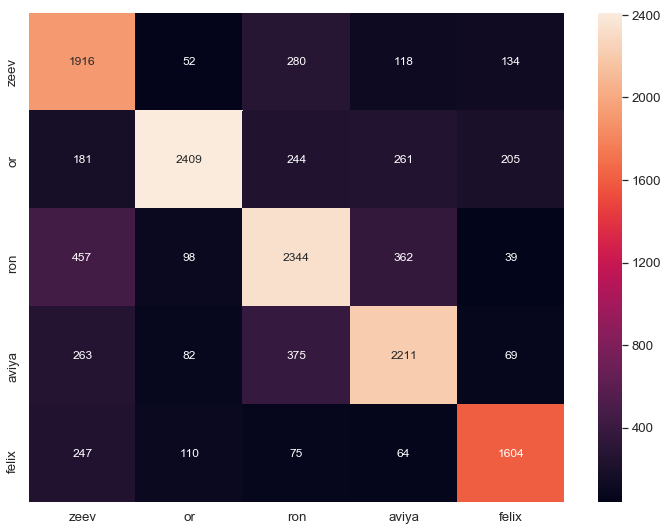

In [45]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(confusion, labels, labels)
plt.figure(figsize = (12, 9))
sn.set(font_scale=1.2)
sn.heatmap(df_cm, annot=True, fmt='.5g', annot_kws={"size": 12})

In [134]:
df_cm

,zeev,or,ron,aviya,felix
zeev,1916,52,280,118,134
or,181,2409,244,261,205
ron,457,98,2344,362,39
aviya,263,82,375,2211,69
felix,247,110,75,64,1604


In [132]:
import random

# plot decision per label
plot_dict = {}
for label in tqdm(range(0, len(np.unique(y_test)))):
    label_data = []
    random.shuffle(y_test)
    for i in y_test[:1000]:
        if i == label:
            label_data.append(test_predicted[i]*100)
    plot_dict[label] = label_data

100%|██████████| 5/5 [00:00<00:00, 51.54it/s]


In [164]:
plt.rcParams["figure.figsize"] = (5,5)

100%|██████████| 163/163 [00:00<00:00, 304.49it/s]


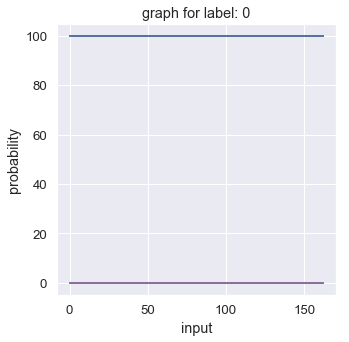

100%|██████████| 253/253 [00:00<00:00, 297.17it/s]


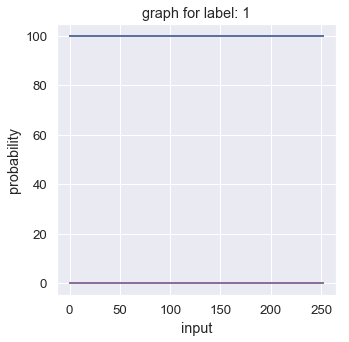

100%|██████████| 241/241 [00:00<00:00, 301.88it/s]


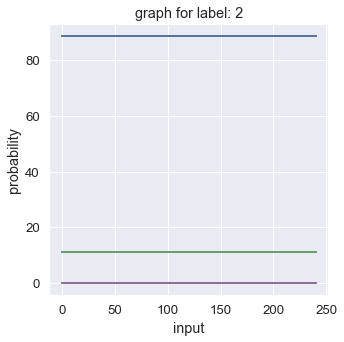

100%|██████████| 218/218 [00:00<00:00, 309.76it/s]


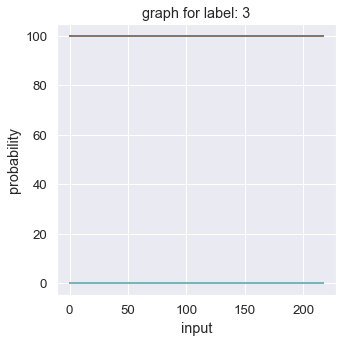

100%|██████████| 150/150 [00:00<00:00, 313.09it/s]


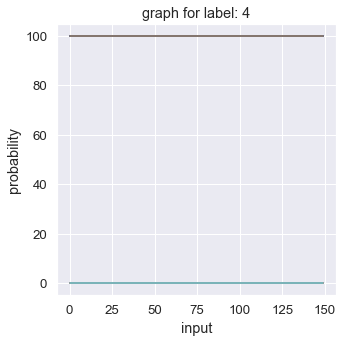

In [165]:
for label, val_lists in plot_dict.items():
    plt.xlabel('input')
    plt.ylabel('probability')
    plt.title('graph for label: {0}'.format(label))
    for i in tqdm(range(len(val_lists))):
        plt.plot(np.arange(0, len(val_lists)), [pt[:5] for pt in val_lists])
#     plt.legend()
    plt.show()

100%|██████████| 163/163 [00:00<00:00, 5854.51it/s]


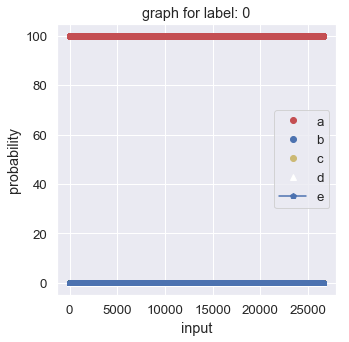

100%|██████████| 253/253 [00:00<00:00, 3402.46it/s]


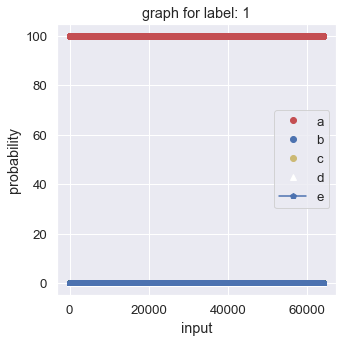

100%|██████████| 241/241 [00:00<00:00, 3523.03it/s]


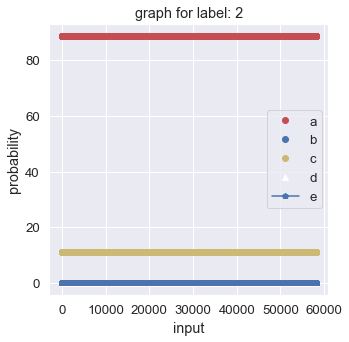

100%|██████████| 218/218 [00:00<00:00, 3757.52it/s]


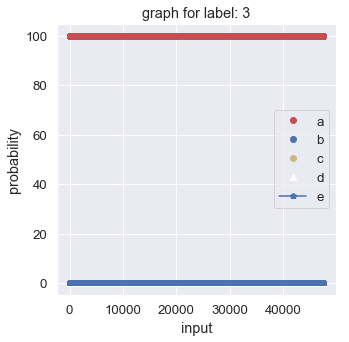

100%|██████████| 150/150 [00:00<00:00, 5423.95it/s]


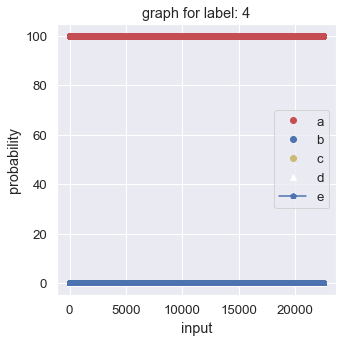

In [177]:
for label, val_lists in plot_dict.items():
    plt.xlabel('input')
    plt.ylabel('probability')
    plt.title('graph for label: {0}'.format(label))
    a = []; b = []; c = []; d = []; e = [];
    for i in tqdm(range(len(val_lists))):
        for lst in val_lists:
            a.append(lst[0])
            b.append(lst[1])
            c.append(lst[2])
            d.append(lst[3])
            e.append(lst[4])
    plt.plot(np.arange(0, len(a)), a, 'ro', label='a')
    plt.plot(np.arange(0, len(b)), b, 'bo', label='b')
    plt.plot(np.arange(0, len(c)), c, 'yo', label='c')
    plt.plot(np.arange(0, len(d)), d, 'w^', label='d')
    plt.plot(np.arange(0, len(e)), e, 'p-', label='e')
    plt.legend()
    plt.show()

In [189]:
def stacked_bar(data, series_labels, category_labels=None, 
                show_values=False, value_format="{}", y_label=None, 
                grid=True, reverse=False):
    """Plots a stacked bar chart with the data and labels provided.

    Keyword arguments:
    data            -- 2-dimensional numpy array or nested list
                       containing data for each series in rows
    series_labels   -- list of series labels (these appear in
                       the legend)
    category_labels -- list of category labels (these appear
                       on the x-axis)
    show_values     -- If True then numeric value labels will 
                       be shown on each bar
    value_format    -- Format string for numeric value labels
                       (default is "{}")
    y_label         -- Label for y-axis (str)
    grid            -- If True display grid
    reverse         -- If True reverse the order that the
                       series are displayed (left-to-right
                       or right-to-left)
    """

    ny = len(data[0])
    ind = list(range(ny))

    axes = []
    cum_size = np.zeros(ny)

    data = np.array(data)

    if reverse:
        data = np.flip(data, axis=1)
        category_labels = reversed(category_labels)

    for i, row_data in enumerate(data):
        axes.append(plt.bar(ind, row_data, bottom=cum_size, 
                            label=series_labels[i]))
        cum_size += row_data

    if category_labels:
        plt.xticks(ind, category_labels)

    if y_label:
        plt.ylabel(y_label)

    plt.legend()

    if grid:
        plt.grid()

    if show_values:
        for axis in axes:
            for bar in axis:
                w, h = bar.get_width(), bar.get_height()
                plt.text(bar.get_x() + w/2, bar.get_y() + h/2, 
                         value_format.format(h), ha="center", 
                         va="center")

KeyboardInterrupt: 

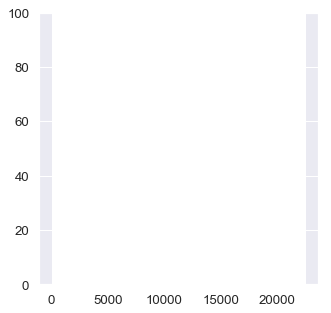

In [190]:
# plt.figure(figsize=(6, 4))

series_labels = ['A', 'B', 'C', 'D', 'E']

data = [a, b, c, d, e]

category_labels = ['A', 'B', 'C', 'D', 'E']

stacked_bar(
    data, 
    series_labels, 
    category_labels=category_labels, 
    show_values=True, 
    value_format="{:.1f}",
    y_label="Accuracy"
)

# plt.savefig('bar.png')
plt.show()